# Étude de la classification sur le dataset du diabète
## Objectif : 
Comparer plusieurs modèles de classification et tester différentes méthodes d'imputation des données manquantes

## 1. Importation des bibliothèques et chargement des données

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer

from imblearn.over_sampling import SMOTE

In [2]:
data = pd.read_csv("diabetes.csv")

## 2. Exploration et nettoyage des données

In [3]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
features_names = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]
cible_name = "Outcome"

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Nous observons des valeurs manquantes pour les variables : Glucose, BloodPressure, SkinThickness, Insulin et BMI

In [6]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


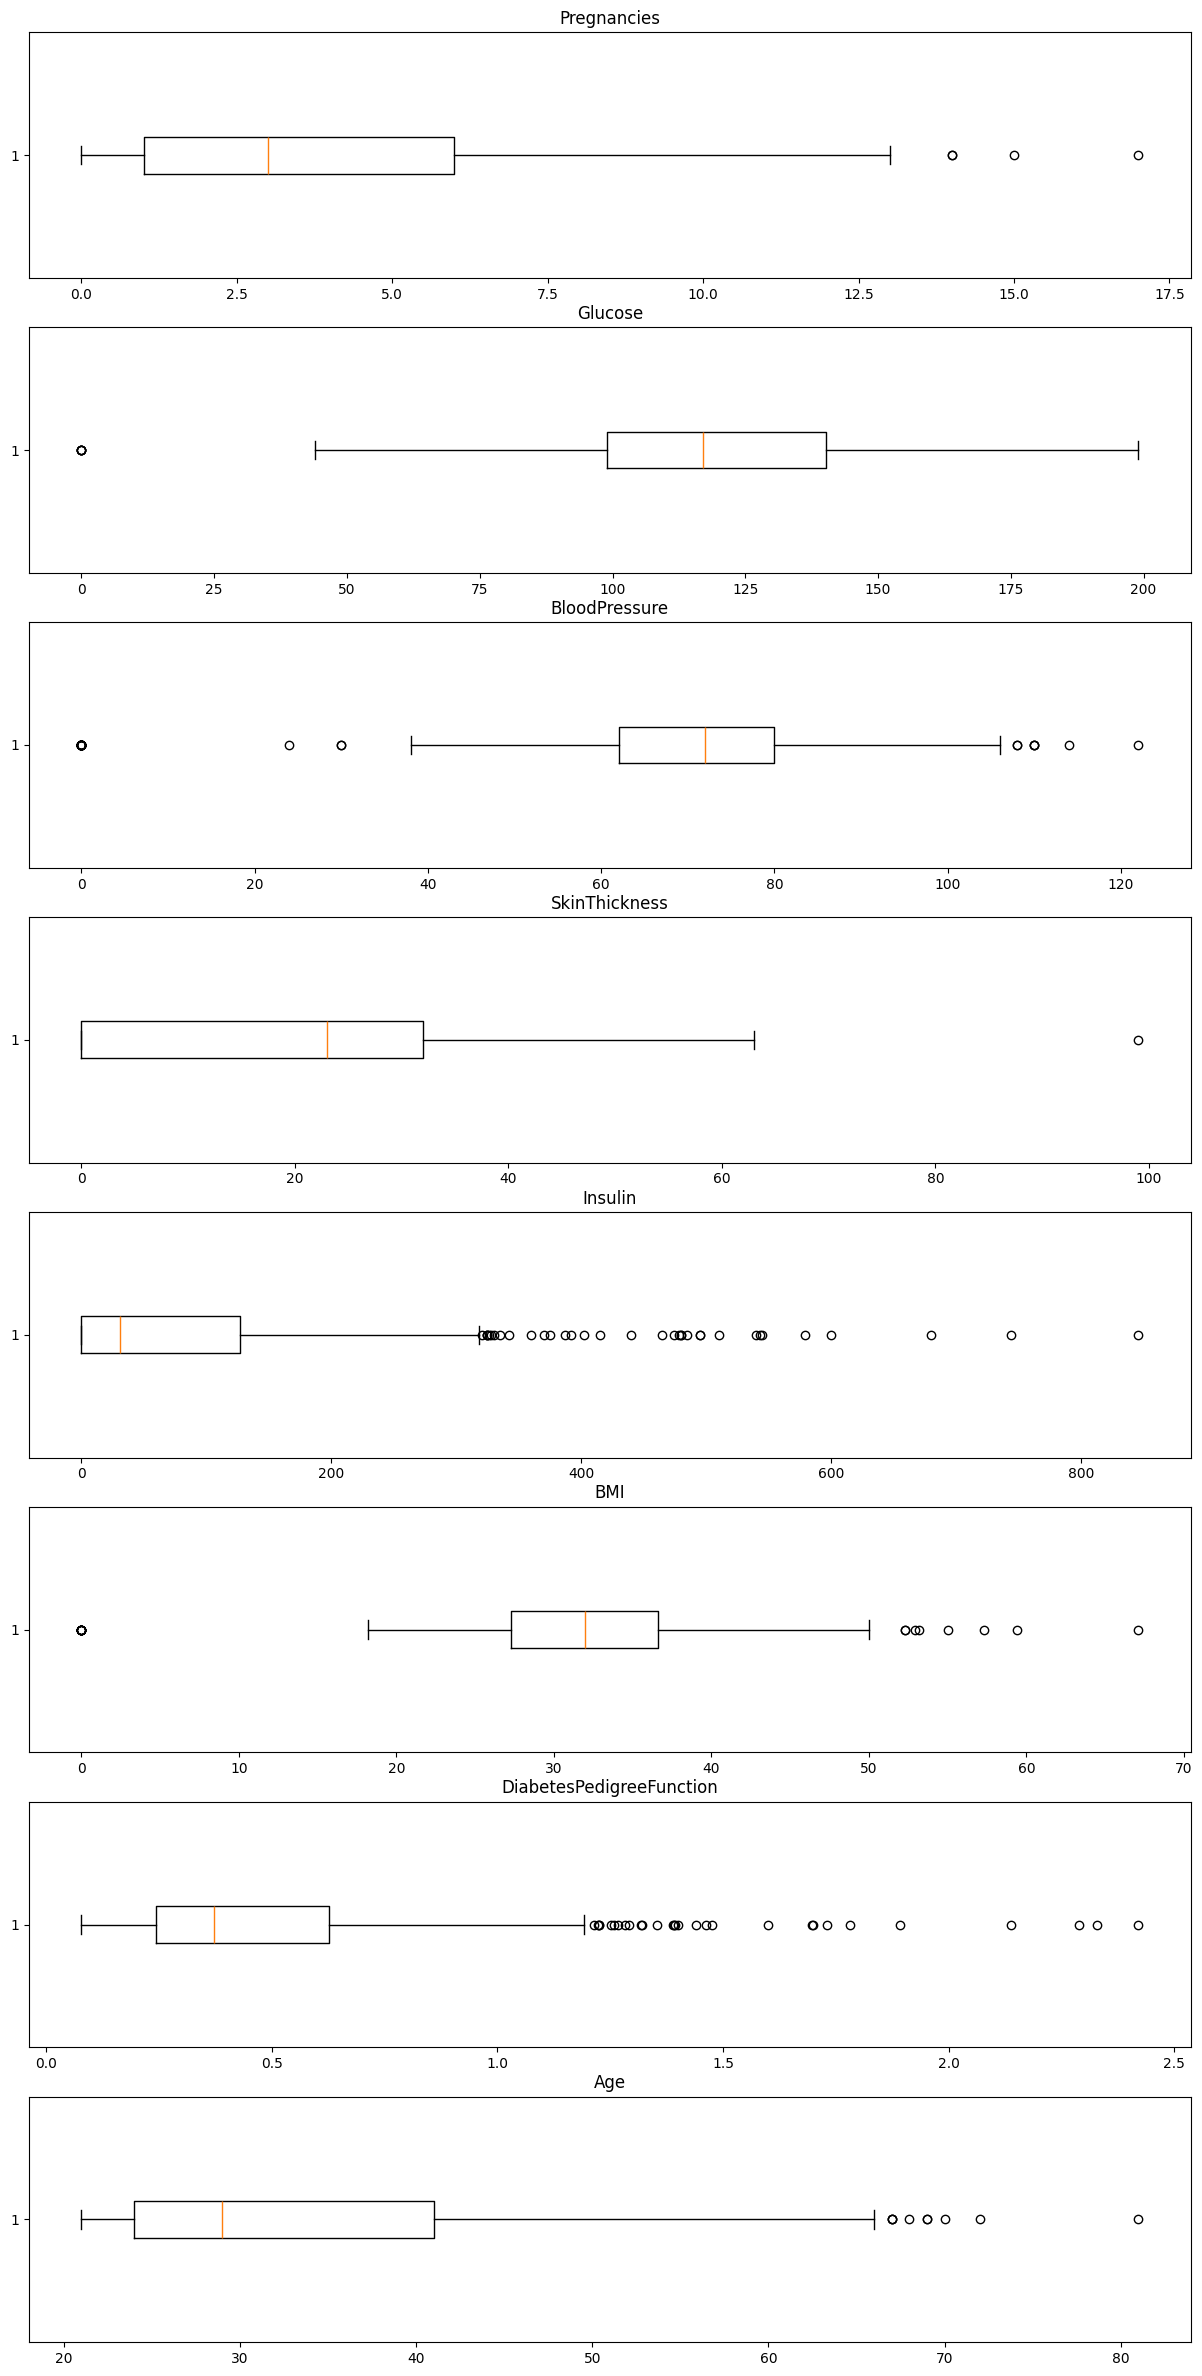

In [7]:
plt.figure(figsize=(15,30))
for i, name in enumerate(features_names):
    plt.subplot(len(features_names), 1, i+1)
    plt.title(name)
    plt.boxplot(data[name], vert=False)

Ajout d'une colonne pour signaler qu'il y a des valeurs manquantes

In [8]:
col_to_check = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

data['HasZero'] = (data[col_to_check] == 0).any(axis=1)
features_names.append('HasZero')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,HasZero
0,6,148,72,35,0,33.6,0.627,50,1,True
1,1,85,66,29,0,26.6,0.351,31,0,True
2,8,183,64,0,0,23.3,0.672,32,1,True
3,1,89,66,23,94,28.1,0.167,21,0,False
4,0,137,40,35,168,43.1,2.288,33,1,False


Vérification de l'équilibre des données

In [9]:
data.loc[data["Outcome"] == 1, "Outcome"].count()

268

In [10]:
data.loc[data["Outcome"] == 0, "Outcome"].count()

500

Il y a deux fois moins de données pour les cas de diabète par rapport aux cas négatifs ce qui peux biaser le résultat. La solution est d'enrichir la classe minoritaire ou d'appauvrir la majoritaire. Ici au choisi le 1er cas pour ne pas perdre de données.

### Séparation en jeu d'entrainement et de test et création de nouveaux exemples synthétiques pour la classe minoritaire (ici outcome=1 donc cas diabétiques)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data[features_names], data[cible_name], test_size=0.2, random_state=24 )
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

### Pour que la classification se passe bien nous allons normaliser et standardiser les données.

In [12]:
scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)


# Utilisant la validation croisée puis entrainement du modèle
## 1 Modèle de régression logistique

In [13]:
model = LogisticRegression()
scores = cross_val_score(model, X_resampled_scaled, y_resampled, cv=5)
print(f'Mean accurancy: {scores.mean()}')
print(f'Accurancy: {scores}')

model.fit(X_resampled_scaled, y_resampled)

Mean accurancy: 0.7512267080745343
Accurancy: [0.73291925 0.83850932 0.67701863 0.77018634 0.7375    ]


LogisticRegression()

In [14]:
y_pred = model.predict(X_test_scaled)

### Affichage des différents scores

In [15]:
def print_metric(y_test, y_pred):
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"Precision score: {precision}")
    print(f"Recall score: {recall}")
    print(f"f1 score: {f1}")
    print(f"Confusion matrix: \n{cm}")

    print("Rapport de classification :\n", classification_report(y_test, y_pred))

print_metric(y_test, y_pred)

Precision score: 0.6271186440677966
Recall score: 0.6607142857142857
f1 score: 0.6434782608695652
Confusion matrix: 
[[76 22]
 [19 37]]
Rapport de classification :
               precision    recall  f1-score   support

           0       0.80      0.78      0.79        98
           1       0.63      0.66      0.64        56

    accuracy                           0.73       154
   macro avg       0.71      0.72      0.72       154
weighted avg       0.74      0.73      0.74       154



## 2 Algorithme des K-Nearest Neighbors (KNN)

In [16]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': [2, 3, 4, 5, 7, 9]}
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_resampled_scaled, y_resampled)
print(f"Best k: {grid_search.best_params_}")


Best k: {'n_neighbors': 7}


In [17]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_resampled_scaled, y_resampled)
y_knn_pred = knn.predict(X_test_scaled)

### Affichage des différents scores

In [18]:
print_metric(y_test, y_knn_pred)

Precision score: 0.5901639344262295
Recall score: 0.6428571428571429
f1 score: 0.6153846153846154
Confusion matrix: 
[[73 25]
 [20 36]]
Rapport de classification :
               precision    recall  f1-score   support

           0       0.78      0.74      0.76        98
           1       0.59      0.64      0.62        56

    accuracy                           0.71       154
   macro avg       0.69      0.69      0.69       154
weighted avg       0.71      0.71      0.71       154



L'algorithme des k plus proches voisins est moins bon. 

In [19]:
param_grid = {
    'n_estimators': [50, 100, 150, 200, 300],  
    'max_depth': [2, 40, 50, 70, 100, 150], 
    'max_features': [None, 'sqrt', 'log2']  
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=24), param_grid, cv=5, scoring='recall')
grid_search.fit(X_resampled_scaled, y_resampled)
print(f'Best parameters: {grid_search.best_params_}')



Best parameters: {'max_depth': 40, 'max_features': 'sqrt', 'n_estimators': 200}


In [22]:
rf = RandomForestClassifier(n_estimators=200, random_state=24, max_features='sqrt', max_depth=40)
rf.fit(X_resampled_scaled, y_resampled)
y_rf_pred = rf.predict(X_test_scaled)

In [23]:
print_metric(y_test, y_rf_pred)

Precision score: 0.6037735849056604
Recall score: 0.5714285714285714
f1 score: 0.5871559633027523
Confusion matrix: 
[[77 21]
 [24 32]]
Rapport de classification :
               precision    recall  f1-score   support

           0       0.76      0.79      0.77        98
           1       0.60      0.57      0.59        56

    accuracy                           0.71       154
   macro avg       0.68      0.68      0.68       154
weighted avg       0.70      0.71      0.71       154



Le modèle des arbres est moins bon que celui de regression logistique.